# Dual-Polarimetric Radar Analysis from Smartphone Photos
---
### Carter J. Humphreys
Email: [chumphre@oswego.edu](mailto:chumphre@oswego.edu) | GitHub:[@HumphreysCarter](https://github.com/HumphreysCarter) | Website: [carterhumphreys.com](http://carterhumphreys.com/)

Version 1.0.0 — 05 May 2020

In [25]:
import ExtractEXIF
import math
import NEXRADpolling as NEXRAD
import s3fs as AWSbucket
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import pandas as pd
from metpy.plots import USCOUNTIES, colortables
from datetime import datetime, timedelta

fs = AWSbucket.S3FileSystem(anon=True)

# Settings

In [26]:
dataDir = '../data/'
markerSymbol='o'
markerColor='k'
markerSize=4
figWidth=24
figHeight=14
figDPI=100

In [27]:
# UCAR THREDDS NEXRAD Site Listing
radarDatabase = pd.read_csv(f'{dataDir}/ucar_thredds_radar_site_list.csv')

earthRadiusKM = 6378.1

def degreesToRadians(degrees):
    return degrees * (math.pi / 180)

def radiansToDegrees(radians):
    return radians * (180 / math.pi)

# Returns distance between two lat/lon points in NM
def distanceBetweenPoints(lat1, lon1, lat2, lon2):
        theta = lon1 - lon2
        dist = math.sin(degreesToRadians(lat1)) * math.sin(degreesToRadians(lat2)) + math.cos(degreesToRadians(lat1)) * math.cos(degreesToRadians(lat2)) * math.cos(degreesToRadians(theta))
        dist = math.acos(dist)
        dist = radiansToDegrees(dist)
        return dist * 60

# Finds closest NEXRAD radar to given lat lon, returns array: [radarID, radarDis[km], radarLat, radarLon]
def findNearestRadar(photoLat, photoLon):
    closestDistance = 9999
    for index, row in radarDatabase.iterrows():
        d = distanceBetweenPoints(photoLat, photoLon, row['latitude'], row['longitude'])

        if d < closestDistance:
            closest = row['id']
            closestDistance = d
    return closest

# Returns elevation,latitude,longitude,name,country,state from NEXRAD site ID
def getRadarMetadata(site):
    radarDatabase = pd.read_csv(f'{dataDir}/ucar_thredds_radar_site_list.csv')
    for index, row in radarDatabase.iterrows(): 
        if row['id'] == site:
            return row
    return None

# Returns new lat/lon point from distance (KM), bearing, and initial lat/lon point
def getLatLonfromAzRng(lat, lon, az, d_km):
    originLatInRadians = math.radians(lat)
    originLonInRadians = math.radians(lon)
    angularDistance = d_km / earthRadiusKM
    bearingInRadians = math.radians(az)

    destLatInRadians=math.asin(math.sin(originLatInRadians) * math.cos(angularDistance) + math.cos(originLatInRadians) * math.sin(angularDistance) * math.cos(bearingInRadians))
    destLonInRadians=originLonInRadians + math.atan2(math.sin(bearingInRadians) * math.sin(angularDistance) * math.cos(originLatInRadians), math.cos(angularDistance) - math.sin(originLatInRadians) * math.sin(destLatInRadians))

    return {'latitude':math.degrees(destLatInRadians), 'longitude':math.degrees(destLonInRadians)}

# Process Photo Data

In [28]:
photoDir=f'{dataDir}/pictures/'
df = pd.read_csv(f'{dataDir}/picture_list.csv')
df.insert(2, 'RadarFile', np.nan)

index = 0
for i, row in df.iterrows():
    # Check if file exists
    fileExists = False
    try:
        f = open(f'{photoDir}/{row["FileName"]}')
        f.close()
        fileExists = True
    except IOError:
        print(f'ERROR: Could not find file {photoDir}/{row["FileName"]}')
    
    # Extract EXIF data
    if fileExists:
        badData = False

        # Extract EXIF from photo
        UTCoffset=row['UTCoffset']
        autoDateTime = ('auto' in row['PhotoDateTime'])
        autoLatLon = ('auto' in row['PhotoLatitude'] and 'auto' in row['PhotoLongitude'])
        exifData = ExtractEXIF.getEXIF(f'{photoDir}/{row["FileName"]}', autoDateTime, autoLatLon)

        # Check EXIF date/time and add UTC offset
        if (autoDateTime == False) or (exifData['Time'] == -9999):
            print('WARNING: Using manual date and time entry for {photoName}')
            try:
                photoDateTime = datetime.strptime(photoDateTime, '%Y:%m:%d %H:%M:%S') - timedelta(hours=UTCoffset)
            except:
                print('ERROR: Bad format: {photoDateTime}. Unable to use date and time entry for {row["FileName"]}')
                badData = True
        else:
            photoDateTime = exifData['Time'] - timedelta(hours=UTCoffset)

        # Check EXIF lat/lon values
        if (autoLatLon == False) or (exifData['Latitude'] == -99.99 or exifData['Longitude'] == -99.99):
            print('WARNING: Using manual lat/lon entry for {photoName}')
            try:
                photoLat = float(photoLat)
                photoLon = float(photoLon)
            except:
                print('ERROR: Non-number: {photoLat}, {photoLon}. Unable to use lat/lon entry for {row["FileName"]}')
                badData = True
        else:
            photoLat = exifData['Latitude']
            photoLon = exifData['Longitude']
        
        if badData == False:
            #
            df.iloc[index, df.columns.get_loc('PhotoLatitude')] = photoLat
            df.iloc[index, df.columns.get_loc('PhotoLongitude')] = photoLon
            df.iloc[index, df.columns.get_loc('PhotoDateTime')] = photoDateTime
            
            # Find radar closest to photo location
            radarID = findNearestRadar(photoLat, photoLon)

            # Find radar scan closest to photo capture
            dataFile=NEXRAD.getArchivedScan(radarID, photoDateTime)
            radarPath=f'{dataDir}/NEXRAD/NEXRAD_L2_{radarID}_{photoDateTime.strftime("%Y%m%d_%H%M%S")}'
            
            # Download NEXRAD file if not already
            try:
                f = open(radarPath)
                f.close()
            except IOError:
                fs.get(dataFile, radarPath)
            
            # Add radar file to database
            df.iloc[index, df.columns.get_loc('RadarFile')] = f'NEXRAD_L2_{radarID}_{photoDateTime.strftime("%Y%m%d_%H%M%S")}' 
            
    # Go to next index
    index+=1   
    
df=df.drop(['UTCoffset', 'Rotation'], axis=1)
df

,EventType,FileName,RadarFile,PhotoLatitude,PhotoLongitude,PhotoDateTime,PhotoBearing,LocationDescription,TakenBy
0,Wall Cloud/Mammatus,IMG_5596.jpg,NEXRAD_L2_KFTG_20190609_000127,39.366,-103.879,2019-06-09 00:01:27,W,"Limon, CO",Carter Humphreys
1,Mammatus,IMG_5630.jpg,NEXRAD_L2_KFTG_20190609_001744,39.3659,-103.879,2019-06-09 00:17:44,W,"Limon, CO",Carter Humphreys
2,Shelf Cloud,IMG_5318.jpg,NEXRAD_L2_KMAF_20190603_013203,32.7992,-103.845,2019-06-03 01:32:03,W,"Loco Hills, NM",Carter Humphreys
3,Shelf Cloud,IMG_5029.jpg,NEXRAD_L2_KAMA_20190602_003653,35.28,-101.846,2019-06-02 00:36:53,WNW,"Amarillo, TX",Carter Humphreys


# Radar Data Plot

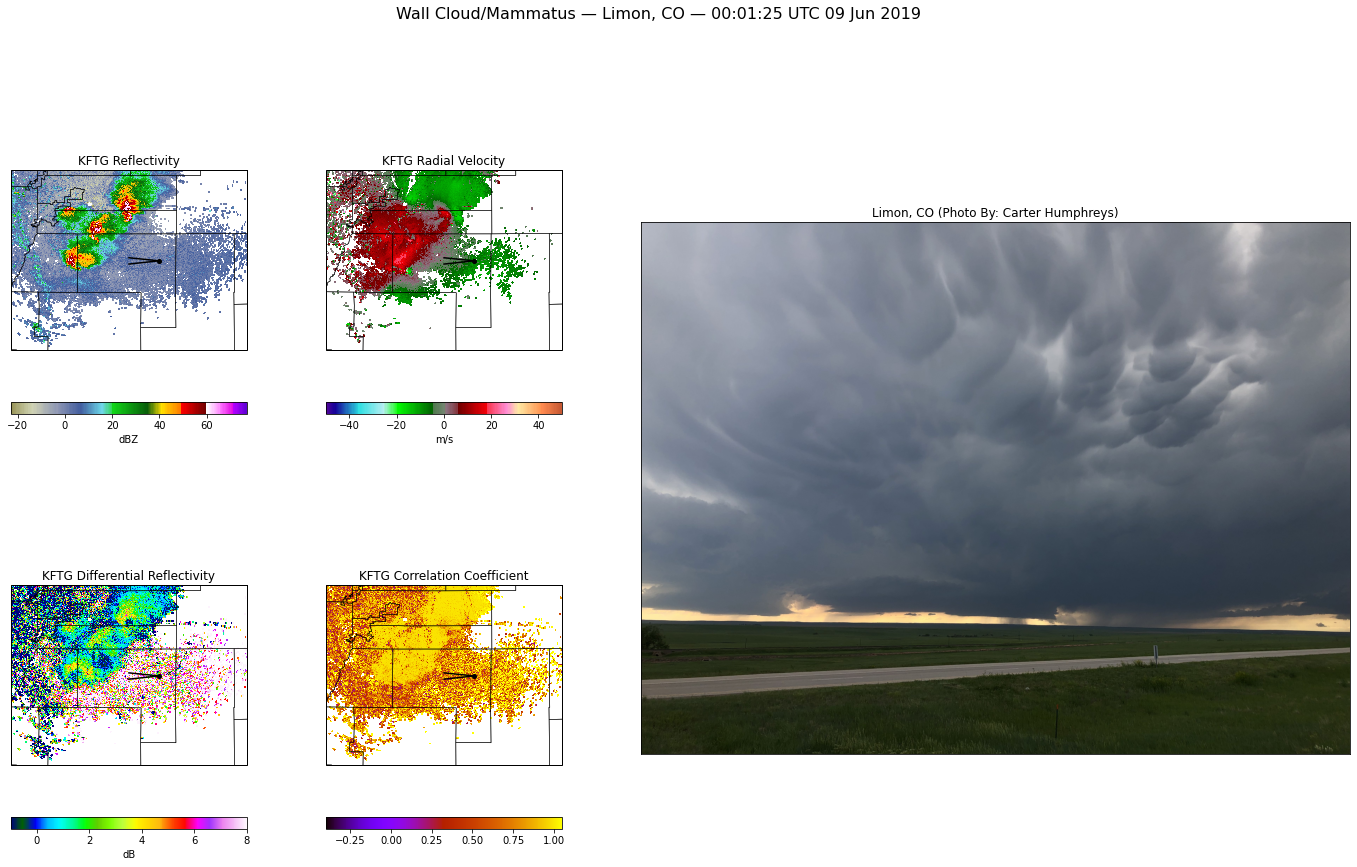

In [29]:
for i, row in df.iterrows():
    # Read in data
    radar = pyart.io.read_nexrad_archive(f'{dataDir}/NEXRAD/{row["RadarFile"]}')
    display = pyart.graph.RadarMapDisplay(radar)

    # Metadata
    radarMetadata=getRadarMetadata(radar.metadata['instrument_name'])
    time=datetime.strptime(radar.time['units'], 'seconds since %Y-%m-%dT%H:%M:%SZ')
    
    # Calculate Field of View
    cardinalToDegrees={'N':360, 'NNE':22.5, 'NE':45, 'ENE':67.5, 'E':90, 'ESE':112.5, 'SE':135, 'SSE':157.5, 'S':180, 'SSW':202.5, 'SW':225, 'WSW':247.5, 'W':270, 'WNW':292.5, 'NW':315, 'NNW':337.5}
    viewDirection=cardinalToDegrees[row['PhotoBearing']]
    leftLimit=getLatLonfromAzRng(row['PhotoLatitude'], row['PhotoLongitude'], viewDirection-6, 25)
    sightLine=getLatLonfromAzRng(row['PhotoLatitude'], row['PhotoLongitude'], viewDirection, 25)
    rightLimit=getLatLonfromAzRng(row['PhotoLatitude'], row['PhotoLongitude'], viewDirection+6, 25)

    # Setup projection
    plotExtent=[sightLine['longitude']-1.125, sightLine['longitude']+1.125, sightLine['latitude']-0.67, sightLine['latitude']+0.67]
    proj = ccrs.LambertConformal(central_longitude=((plotExtent[1]-plotExtent[0])/2+plotExtent[0]), central_latitude=((plotExtent[3]-plotExtent[2])/2+plotExtent[2]))
    lon_lines=np.arange(round(plotExtent[0]-1, 0), round(plotExtent[1]+1, 0), 0.5)
    lat_lines=np.arange(round(plotExtent[2]-1, 0), round(plotExtent[3]+1, 0), 0.5)

    # Setup plot
    fig = plt.figure(figsize=(figWidth, figHeight))
    gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[1, 1, 3])
    
    # Reflectivity Plot
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    z_cmap = colortables.get_colortable('NWSStormClearReflectivity')
    display.plot_ppi_map('reflectivity', 0, vmin=-23, vmax=77, ax=ax1, colorbar_flag=False, cmap=z_cmap, title=f'{radarMetadata["id"]} Reflectivity', raster=True, 
                         embelish=False, min_lon=plotExtent[0], max_lon=plotExtent[1], min_lat=plotExtent[2], max_lat=plotExtent[3])
    display.plot_colorbar(ax=ax1, orient='horizontal', label='dBZ')
    
    # Plot photo location and geo line
    display.plot_point(row['PhotoLongitude'], row['PhotoLatitude'], symbol=markerSymbol, color=markerColor, markersize=markerSize)
    display.plot_line_geo([row['PhotoLongitude'], leftLimit['longitude']], [row['PhotoLatitude'], leftLimit['latitude']], color=markerColor)
    display.plot_line_geo([row['PhotoLongitude'], rightLimit['longitude']], [row['PhotoLatitude'], rightLimit['latitude']], color=markerColor)

    # Radial Velocity Plot
    ax2 = fig.add_subplot(gs[0, 1], projection=proj)
    v_cmap = colortables.get_colortable('NWS8bitVel')
    display.plot_ppi_map('velocity', 1, vmin=-50, vmax=50, colorbar_flag=False, ax=ax2, cmap=v_cmap, title=f'{radarMetadata["id"]} Radial Velocity', raster=True, 
                         embelish=False, min_lon=plotExtent[0], max_lon=plotExtent[1], min_lat=plotExtent[2], max_lat=plotExtent[3])
    display.plot_colorbar(ax=ax2, orient='horizontal', label='m/s')
    # Plot photo location and geo line
    display.plot_point(row['PhotoLongitude'], row['PhotoLatitude'], symbol=markerSymbol, color=markerColor, markersize=markerSize)
    display.plot_line_geo([row['PhotoLongitude'], leftLimit['longitude']], [row['PhotoLatitude'], leftLimit['latitude']], color=markerColor)
    display.plot_line_geo([row['PhotoLongitude'], rightLimit['longitude']], [row['PhotoLatitude'], rightLimit['latitude']], color=markerColor)

    # Differential Reflectivity Plot
    ax3 = fig.add_subplot(gs[1, 0], projection=proj)
    display.plot_ppi_map('differential_reflectivity', 0, vmin=-1, vmax=8, colorbar_flag=False, ax=ax3, cmap='gist_ncar', title=f'{radarMetadata["id"]} Differential Reflectivity', 
                         raster=True, embelish=False, min_lon=plotExtent[0], max_lon=plotExtent[1], min_lat=plotExtent[2], max_lat=plotExtent[3])
    display.plot_colorbar(ax=ax3, orient='horizontal', label='dB')
    # Plot photo location and geo line
    display.plot_point(row['PhotoLongitude'], row['PhotoLatitude'], symbol=markerSymbol, color=markerColor, markersize=markerSize)
    display.plot_line_geo([row['PhotoLongitude'], leftLimit['longitude']], [row['PhotoLatitude'], leftLimit['latitude']], color=markerColor)
    display.plot_line_geo([row['PhotoLongitude'], rightLimit['longitude']], [row['PhotoLatitude'], rightLimit['latitude']], color=markerColor)

    # Correlation Coefficient
    ax4 = fig.add_subplot(gs[1, 1], projection=proj)
    display.plot_ppi_map('cross_correlation_ratio', 0, vmin=-0.4, vmax=1.05, colorbar_flag=False, ax=ax4, cmap='gnuplot', title=f'{radarMetadata["id"]} Correlation Coefficient', 
                         raster=True, embelish=False, min_lon=plotExtent[0], max_lon=plotExtent[1], min_lat=plotExtent[2], max_lat=plotExtent[3])
    display.plot_colorbar(ax=ax4, orient='horizontal', label='')
    # Plot photo location and geo line
    display.plot_point(row['PhotoLongitude'], row['PhotoLatitude'], symbol=markerSymbol, color=markerColor, markersize=markerSize)
    display.plot_line_geo([row['PhotoLongitude'], leftLimit['longitude']], [row['PhotoLatitude'], leftLimit['latitude']], color=markerColor)
    display.plot_line_geo([row['PhotoLongitude'], rightLimit['longitude']], [row['PhotoLatitude'], rightLimit['latitude']], color=markerColor)

    axs=[ax1, ax2, ax3, ax4]
    for ax in axs:
        # Add geographic features
        state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
        ax.add_feature(state_borders, edgecolor='black', linewidth=2.0)
        ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)
    
    # Add image to plot
    img = mpimg.imread(f'{photoDir}/{row["FileName"]}')
    ax5 = fig.add_subplot(gs[:, 2:])
    ax5.imshow(img)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.set_title(f'{row["LocationDescription"]} (Photo By: {row["TakenBy"]})')
    
    # Plot Title
    radarName=radarMetadata['name']
    radarName=radarName[:radarName.index('/')].replace('_', ' ')
    plt.suptitle(f'{row["EventType"]} — {row["LocationDescription"]} — {time.strftime("%H:%M:%S UTC %d %b %Y")}', fontsize=16)
    
    plt.show()
    break # Remove this line to export all images
    
    # Export and Close
    ImageName=row['FileName']
    ImageName=ImageName[:ImageName.index(".")]
    eventType=row['EventType'].replace(' ', '_').replace('/', '_')
    exportFileName=f'PhotoRadarAnalysis_{ImageName}_{eventType}_with_photo.png'
    fig.savefig(f'{dataDir}/analysis/{exportFileName}', bbox_inches='tight', dpi=figDPI)
    plt.clf()